<a href="https://colab.research.google.com/github/vrmusketeers/FYP-2021/blob/master/notebooks/neural_net/VG_16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Package Import

In [18]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
!rm -rf '/content/drive/Shareddrives/Final Project/FmriTrainTestData/VG16-Data/Output/train/.ipynb_checkpoints'
!rm -rf '/content/drive/Shareddrives/Final Project/FmriTrainTestData/VG16-Data/Output/test/.ipynb_checkpoints'
!rm -rf '/content/drive/Shareddrives/Final Project/FmriTrainTestData/VG16-Data/Output/val/.ipynb_checkpoints'

In [20]:
import os 
import zipfile 
import tensorflow as tf 
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras import layers 
from tensorflow.keras import Model 
import matplotlib.pyplot as plt

# Image data generator
We instantiate generator and transformer in ordet to manipulate the images.

In [21]:
# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,rotation_range = 40, width_shift_range = 0.2, height_shift_range = 0.2, shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

In [32]:
# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory('/content/drive/Shareddrives/Final Project/FmriTrainTestData/VG16-Data/Output/train', batch_size = 20, class_mode = 'binary', target_size = (224, 224))

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = test_datagen.flow_from_directory('/content/drive/Shareddrives/Final Project/FmriTrainTestData/VG16-Data/Output/val',  batch_size = 20, class_mode = 'binary', target_size = (224, 224))

# Flow validation images in batches of 20 using test_datagen generator
test_generator = test_datagen.flow_from_directory('/content/drive/Shareddrives/Final Project/FmriTrainTestData/VG16-Data/Output/test',  batch_size = 20, class_mode = 'binary', target_size = (224, 224))

Found 6968 images belonging to 2 classes.
Found 871 images belonging to 2 classes.
Found 871 images belonging to 2 classes.


# Modeling and Architecture

We import VGG-16 model and this uses the iamges in order to process the data.
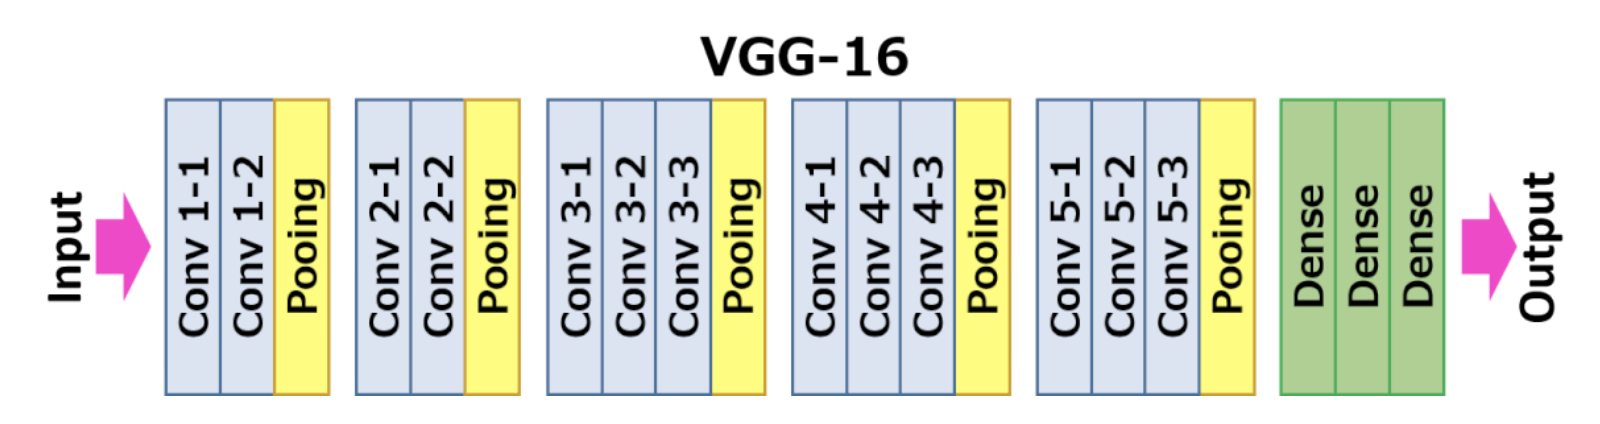

## Loading the Base Model

In [23]:
from tensorflow.keras.applications.vgg16 import VGG16

base_model = VGG16(input_shape = (224, 224, 3), # Shape of our images
include_top = False, # Leave out the last fully connected layer
weights = 'imagenet')

### Since we don’t have to train all the layers, we make them non_trainable:

In [24]:
# Freeze four convolution blocks
for layer in base_model.layers[:15]:
    layer.trainable = False
# Make sure you have frozen the correct layers
for i, layer in enumerate(base_model.layers):
    print(i, layer.name, layer.trainable)

0 input_2 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True


In [25]:
# Flatten the output layer to 1 dimension
x = layers.Flatten()(base_model.output)

# Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(512, activation='relu')(x)

# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)

# Add a final sigmoid layer with 1 node for classification output
x = layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.models.Model(base_model.input, x)

model.compile(optimizer = tf.keras.optimizers.RMSprop(lr=0.0001), loss = 'binary_crossentropy',metrics = ['acc'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [26]:
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.6, patience=8, verbose=1, mode='max', min_lr=5e-5)
checkpoint = ModelCheckpoint('vgg16_finetune.h15', monitor= 'val_accuracy', mode= 'max', save_best_only = True, verbose= 1)

##  Compile and Fit

In [27]:
from tensorflow.keras import layers, models, Model, optimizers
learning_rate= 5e-5
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=learning_rate), metrics=["accuracy"])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [28]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [29]:
history = model.fit(train_generator, batch_size = 32, epochs=20, validation_data=validation_generator, steps_per_epoch = 20, callbacks=[lr_reduce,checkpoint])

Epoch 1/20
20/20 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.4500
Epoch 00001: val_accuracy improved from -inf to 0.46269, saving model to vgg16_finetune.h15
INFO:tensorflow:Assets written to: vgg16_finetune.h15/assets
20/20 [==============================] - 144s 7s/step - loss: 0.0000e+00 - accuracy: 0.4500 - val_loss: 0.0000e+00 - val_accuracy: 0.4627 - lr: 5.0000e-05
Epoch 2/20
20/20 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.4625
Epoch 00002: val_accuracy did not improve from 0.46269
20/20 [==============================] - 141s 7s/step - loss: 0.0000e+00 - accuracy: 0.4625 - val_loss: 0.0000e+00 - val_accuracy: 0.4627 - lr: 5.0000e-05
Epoch 3/20
20/20 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.4825
Epoch 00003: val_accuracy did not improve from 0.46269
20/20 [==============================] - 129s 6s/step - loss: 0.0000e+00 - accuracy: 0.4825 - val_loss: 0.0000e+00 - val_accuracy: 0.

In [30]:
print(history.history)

{'loss': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'accuracy': [0.44999998807907104, 0.4625000059604645, 0.48249998688697815, 0.4675000011920929, 0.48500001430511475, 0.44999998807907104, 0.4424999952316284, 0.4699999988079071, 0.4625000059604645, 0.4375, 0.4793814420700073, 0.45249998569488525, 0.5274999737739563, 0.49000000953674316, 0.44999998807907104, 0.4749999940395355, 0.4650000035762787, 0.4350000023841858, 0.4300000071525574, 0.45750001072883606], 'val_loss': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'val_accuracy': [0.46268656849861145, 0.46268656849861145, 0.46268656849861145, 0.46268656849861145, 0.46268656849861145, 0.46268656849861145, 0.46268656849861145, 0.46268656849861145, 0.46268656849861145, 0.46268656849861145, 0.46268656849861145, 0.46268656849861145, 0.46268656849861145, 0.46268656849861145, 0.46268656849861145, 0.46268656849861145, 0.4626865684

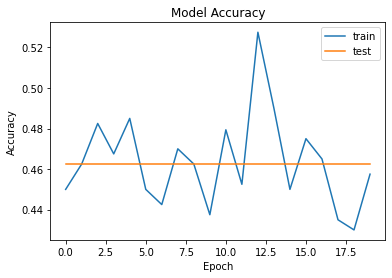

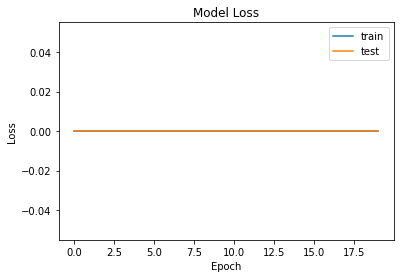

In [31]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [33]:
probabilities = model.predict_generator(generator=test_generator)
y_true = test_generator.classes
y_pred = probabilities > 0.5
font = {
'family': 'Times New Roman',
'size': 12
}
plt.rc('font', **font)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """Entry point for launching an IPython kernel.


findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


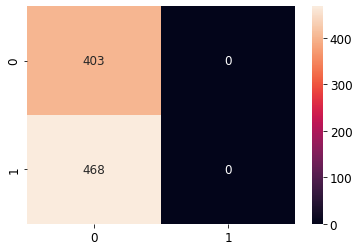

In [34]:
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
mat = confusion_matrix(y_true, y_pred)
# plot_confusion_matrix(conf_mat=mat, figsize=(8, 8), show_normed=False)

#plot_confusion_matrix(model, y_true, y_pred)
f = sns.heatmap(mat, annot=True, fmt='d')